In [6]:
#import dependencies
!pip install numpy
!pip install keras
!pip install PIL
!pip install IPython
!pip install google

tensorflow 1.10.0 has requirement numpy<=1.14.5,>=1.13.3, but you'll have numpy 1.15.2 which is incompatible.
tensorflow 1.10.0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.4.3 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow 1.10.0 has requirement numpy<=1.14.5,>=1.13.3, but you'll have numpy 1.15.2 which is incompatible.
tensorflow 1.10.0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.4.3 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorf

# We will use keras
# Runs on top of tensorflow
# We usea trained model called VGG 16

In [7]:
#import dependencies
import numpy as np
from keras.applications import vgg16
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
#image preprocessing
from PIL import Image as PImage
#display images
from IPython.display import Image
#to increase performances we use l_bfgs a gradient decent optimizer
from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imsave
#in order to know the duration of training we use time
import time

# Upload two Images to Colab

In [8]:
from google.colab import files

files.upload()

ModuleNotFoundError: No module named 'google.colab'

# Verify the imgas uploaded successfully

In [6]:
! ls

bbc		    glove.6B.100d.txt  sample_data
bbc-fulltext.zip    glove.6B.200d.txt  style.jpg
bbc-fulltext.zip.1  glove.6B.300d.txt  vocabulary-embedding.data.pkl
content.jpg	    glove.6B.50d.txt   vocabulary-embedding.pkl
embeddings.pkl	    glove.6B.zip


# Load images and convert them to tensors
## According the way it was made at:
## [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556)

In [7]:
#define imgs paths
contentImgPath = "content.jpg"
styleImgPath = "style.jpg"

#load images and convert to tensors
height = 512
width = 512
resizeDimensions = (height,width)
contentImage = PImage.open(contentImgPath).resize(resizeDimensions)
styleImage = PImage.open(styleImgPath).resize(resizeDimensions)

#reshape the images 
contentArray = np.asarray(contentImage, dtype='float32')
contentArray = np.expand_dims(contentArray, axis=0)
print(contentArray.shape)

styleArray = np.asarray(styleImage, dtype='float32')
styleArray = np.expand_dims(styleArray, axis=0)
print(styleArray.shape)


(1, 512, 512, 3)
(1, 512, 512, 3)


# Create combined placeholder for the 2 images to be able to compate between them

In [0]:
#crate combined placeholder for the images
combinedImage = K.placeholder((1,512,512,3))

# Plot images

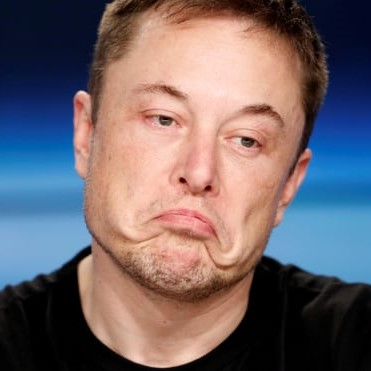

In [9]:
Image(contentImgPath,width=512,height=512)

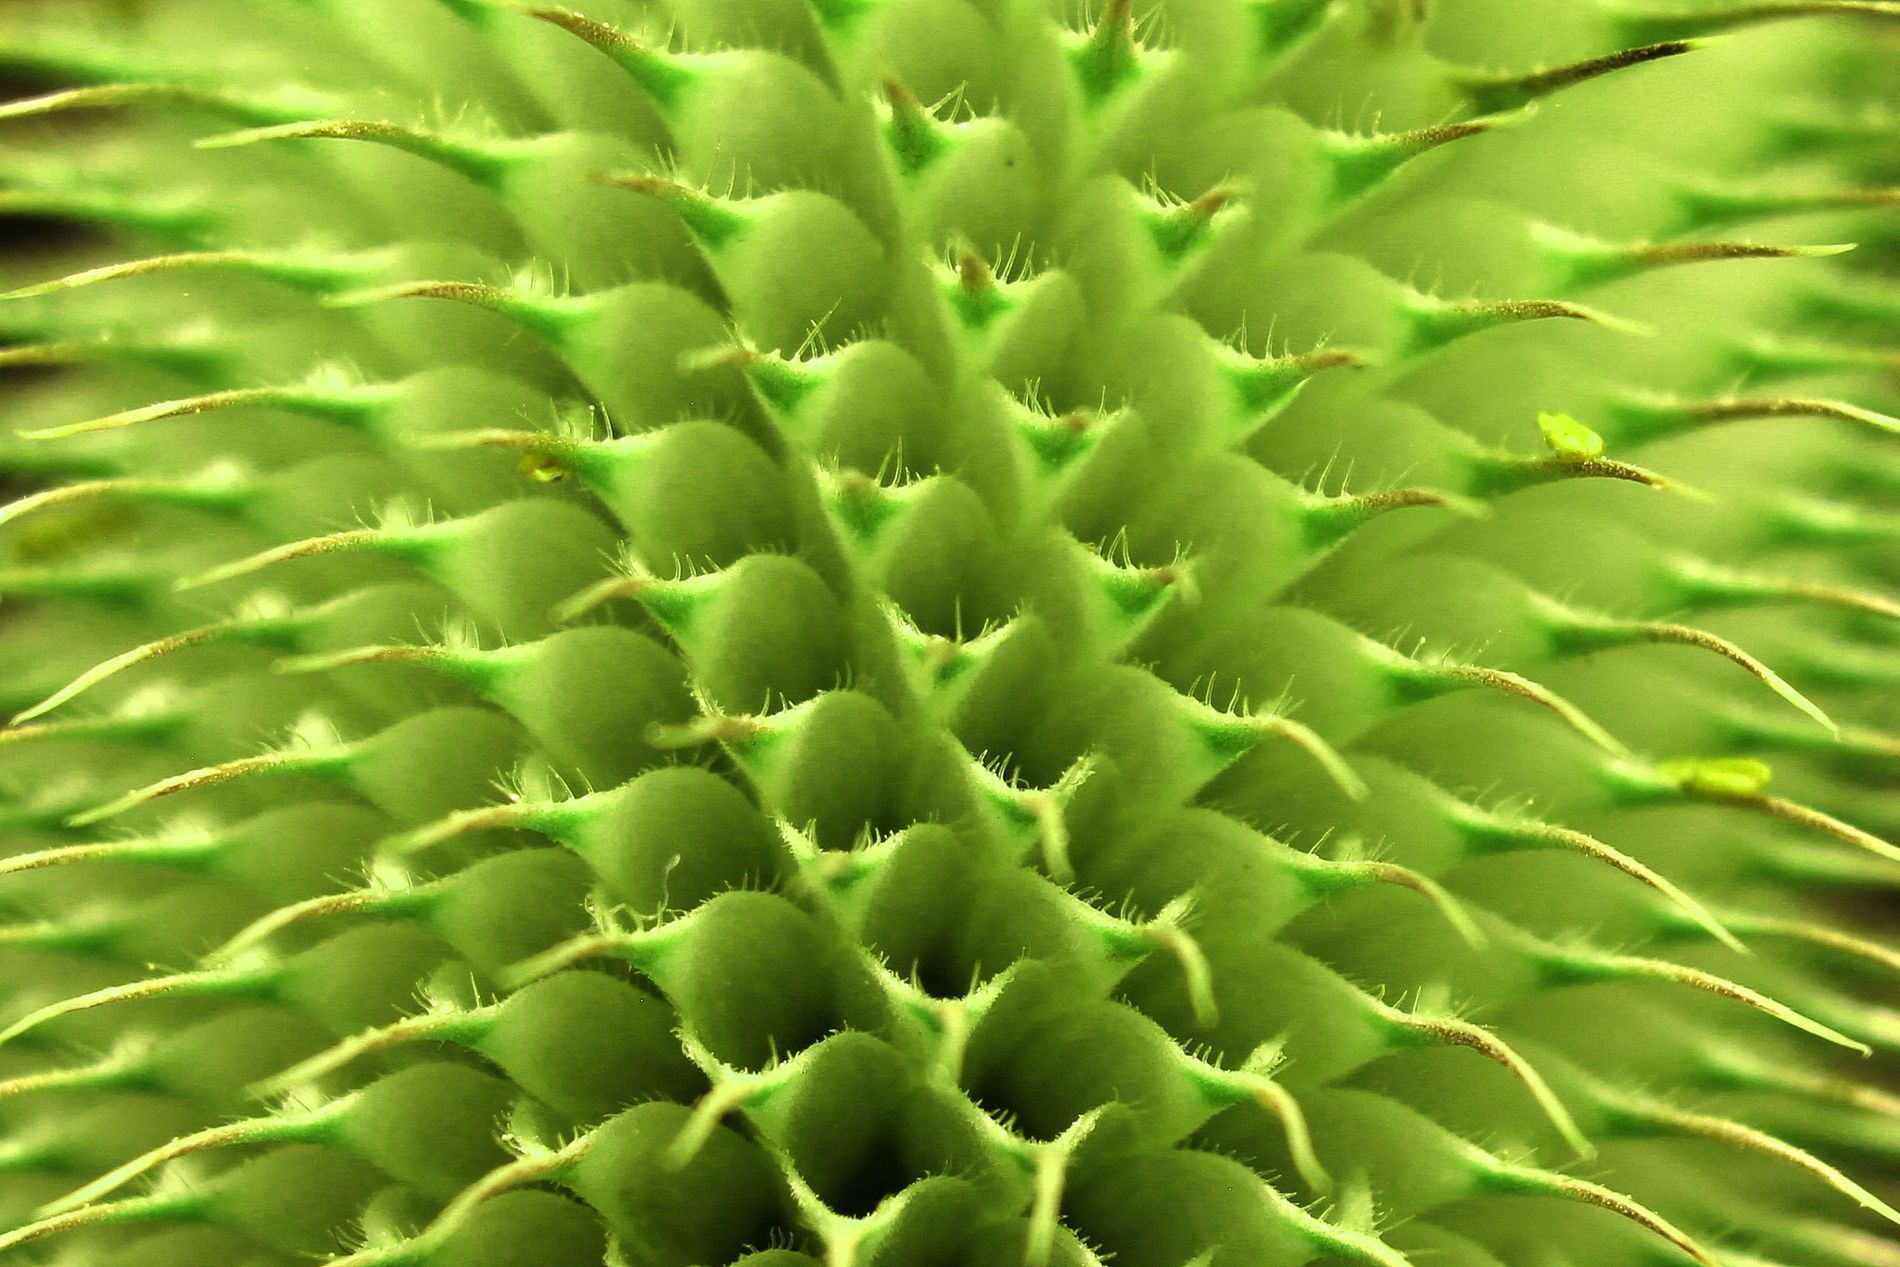

In [10]:
Image(styleImgPath,width=512,height=512)

# Concate the 3 images to a single tensor

In [0]:
# combine the 3 images to a single tensor
inputTensor = K.concatenate([contentArray, styleArray, combinedImage], axis=0)

# Use a trained model called *VGG16*
# with *Imagenet* weights
## Can be imported using Keras

In [12]:
# will use VGG16 with the 3 images as an input
model = vgg16.VGG16(input_tensor = inputTensor, weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 5s 0us/step


# Print the layers of the VGG16 model

In [13]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

# Give weights

In [0]:
content_weight = 0.015
style_weight = 5.0
total_variation_weight = 1.0

# Defining the loss

## Initial the loss as 0

In [0]:
loss = K.variable(0.)

## Defining content loss function

In [0]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

## Choosing layer for content loss

In [0]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

## Applying content loss

In [18]:
loss += content_weight * content_loss(content_image_features,
                                      combination_features)


## Defining style loss function

In [0]:

def  gram_matrix (x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram
  
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

## Choosing layers for style loss and applying the loss

In [0]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3','block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

# Defining the total variation loss

In [0]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


## Applying the variation loss

In [0]:
loss += total_variation_weight * total_variation_loss(combinedImage)

# Defining relevat gradients

In [0]:
gradients = K.gradients(loss,combinedImage)

# We create ***Evaluator*** class to compute loss and gradients more efficiently

In [0]:
outputs = [loss]
outputs += gradients
f_outputs = K.function([combinedImage], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


# Train!

In [25]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 648230200000.0
Iteration 0 completed in 628s
Start of iteration 1
Current loss value: 37231006000.0
Iteration 1 completed in 622s
Start of iteration 2
Current loss value: 25032952000.0
Iteration 2 completed in 623s
Start of iteration 3
Current loss value: 20913609000.0
Iteration 3 completed in 622s
Start of iteration 4
Current loss value: 18691070000.0
Iteration 4 completed in 621s
Start of iteration 5
Current loss value: 17522504000.0
Iteration 5 completed in 621s
Start of iteration 6
Current loss value: 16908620000.0
Iteration 6 completed in 620s
Start of iteration 7
Current loss value: 16441404000.0
Iteration 7 completed in 620s
Start of iteration 8
Current loss value: 16067090000.0
Iteration 8 completed in 621s
Start of iteration 9
Current loss value: 15842937000.0
Iteration 9 completed in 623s


# Plot the new image

In [0]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')


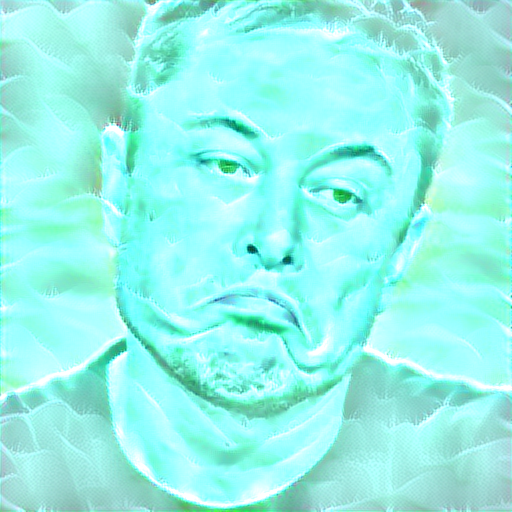

In [27]:

img_result = PImage.fromarray(x)
img_result

# Saving image & download

In [0]:
img_result.save("my_art.jpeg")
files.download('my_art.jpeg') 

img_result.sa